In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
from pathlib import Path
import warnings
from IPython.display import clear_output

# Get the parent directory and add it to sys.path
parent_dir = Path().resolve().parent
sys.path.append(str(parent_dir))

warnings.filterwarnings("ignore")

from data_builder import TimeSeriesBuilder, read_trans, read_labels
from utils import read_data, set_seed, heuristic_alpha, heuristic_alpha2
from models import Model
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from training import train, test
from tqdm import tqdm
import pandas as pd
import numpy as np
import gc

# Set parameters
SEQ_LEN = 10
dim_inputs = 10
hidden_size = 50
latent_size = 50

batch_size = 1024
base_lr = 0.01
lr_step = 10
num_epochs = 100

### 1. Generate time-series by referring to a base gene

In [ ]:
# load transcripts and cell types
folder = '../../Xenium/HumanBoneMarrow/'
data_folder = folder + 'TimeSeries/'
save_path = folder + 'ReferredTimeSeries/'
cell_types = read_labels(filename=folder + 'Cell_Barcode_Type_Matrices.xlsx', sheet='Xenium R1 Fig1-5 (supervised)')
# Fetch the list of genes
gene_list = [f.split('_')[0] for f in os.listdir(data_folder) if f.endswith('.csv')]
gene_list = sorted(list(set(gene_list)))
# set base gene
base_gene = 'GATA3'
gene_list.remove(base_gene)
refer_cell_ids = pd.read_csv(data_folder + base_gene + '_ids.csv').values

for i in range(len(gene_list)):
    gene = gene_list[i]
    clear_output(wait=True)
    print(f'Processing the {i+1}-th gene: {gene}')
    transcripts = read_trans(folder + 'MoleculesPerGene/' + gene + '.csv')
    num_cells = transcripts['cell_id'].nunique()
    # Build time series
    tsb = TimeSeriesBuilder(transcripts, cell_types)
    tsb.run(num_samples=int(num_cells/5), save_path=save_path, gene=gene, method='refer', reference_ids=refer_cell_ids)

### 4. Apply to all the gene pairs
The previous sections showed an example of delay effect on one gene pair. This section focuses on running experiments on all the available TF-gene pairs in the data. The TF-gene pairs used here are extracted by referring to the Msig database.

In [4]:
# 4.1 Load TF-gene pairs
file = '../../Xenium/HumanBoneMarrow/tf_gene_pairs.csv'
tf_gene_pairs = pd.read_csv(file)

In [6]:
# 4.2 Generate time-series samples for all TF-gene pairs
folder = '../../Xenium/HumanBoneMarrow/'
# cell_types = read_labels(filename=folder + 'Cell_Barcode_Type_Matrices.xlsx', sheet='Xenium R1 Fig1-5 (supervised)')
cell_types = read_labels(filename=folder + 'clusters.csv')
for i in range(len(tf_gene_pairs)):
    tf = tf_gene_pairs.iloc[i]['TF']
    gene = tf_gene_pairs.iloc[i]['Gene']
    tf_gene_folder = os.path.join(folder+'DelayPairs/', f"{tf}_{gene}")
    os.makedirs(tf_gene_folder, exist_ok=True)
    clear_output(wait=True)
    print(f'Processing the {i+1}-th TF-gene pair: {tf} - {gene}')

    # Use tf as base gene, generate time-series samples for the regulated gene
    base_gene = tf
    refer_cell_ids = pd.read_csv(folder+'TimeSeries/' + base_gene + '_ids.csv').values
    transcripts = read_trans(folder+'MoleculesPerGene/' + gene + '.csv')
    num_cells = transcripts['cell_id'].nunique()
    tsb = TimeSeriesBuilder(transcripts, cell_types)
    tsb.run(num_samples=int(num_cells/10), save_path=tf_gene_folder+'/', gene=gene, method='refer', reference_ids=refer_cell_ids)

Processing the 6-th TF-gene pair: LEF1 - SPP1
Building cell dictionaries
Build cell feature vectors
1094 time-series samples of SPP1 generated


In [7]:
def easy_test(data_folder, model_folder, gene, SEQ_LEN, dim_inputs, hidden_size, latent_size):
    # load test data
    data_path = data_folder + gene + '_data.csv'
    locs_path = data_folder + gene + '_locs.csv'
    data, locs = read_data(data_path, locs_path, SEQ_LEN, dim_inputs)
    test_data = data
    test_locs = locs
    # load the trained model and start test
    model_path = model_folder + gene + '_model.pth'
    net = Model(dim_inputs, hidden_size, latent_size, SEQ_LEN)
    net.load_state_dict(torch.load(model_path))
    with torch.no_grad():
        prediction, generation, trans_status, loss_recon = test(test_data, test_locs, net)
    return prediction, generation, trans_status, loss_recon

In [8]:
# 4.3 Train and test the model on all the TF-gene pairs
folder = '../../Xenium/HumanBoneMarrow/'

for i in range(len(tf_gene_pairs)):
    tf = tf_gene_pairs.iloc[i]['TF']
    gene = tf_gene_pairs.iloc[i]['Gene']
    tf_gene_folder = os.path.join(folder+'DelayPairs/', f"{tf}_{gene}/")
    clear_output(wait=True)
    print(f'Processing the {i+1}-th TF-gene pair: {tf} - {gene}')

    # Train on the regulated gene
    data_path = tf_gene_folder + gene + '_data.csv'
    locs_path = tf_gene_folder + gene + '_locs.csv'
    if os.path.exists(data_path) and os.path.getsize(data_path) == 0:
        continue
    data, locs = read_data(data_path, locs_path, SEQ_LEN, dim_inputs)
    train_data = data
    train_locs = locs
    set_seed(42)
    alpha = heuristic_alpha2(train_data)
    net, _, _ = train(train_data, train_locs, alpha, batch_size, base_lr, lr_step, num_epochs, hidden_size, latent_size, SEQ_LEN)
    torch.save(net.state_dict(), tf_gene_folder + gene + '_model.pth')
    # Test on the regulated gene
    _, generation, trans_status, _ = easy_test(tf_gene_folder, tf_gene_folder, gene, SEQ_LEN, dim_inputs, hidden_size, latent_size)

    # Test on the saved model of the tf
    data_folder_tf = folder + 'TimeSeries/'
    model_folder_tf = folder + 'Models/'
    _, generation_tf, trans_status_tf, _ = easy_test(data_folder_tf, model_folder_tf, tf, SEQ_LEN, dim_inputs, hidden_size, latent_size)

    # Save the paired velos
    reference = pd.read_csv(tf_gene_folder + gene + '_reference.csv')
    rows = []

    # Loop through all indices in the reference dataframe
    for i in range(len(reference)):
        # Extract reference index
        ref = int(reference.iloc[i])

        # Process generated and base data
        gen = generation[i].view(-1).cpu().detach().numpy()
        status = trans_status[i].view(-1).cpu().detach().numpy()
        gen_tf = generation_tf[ref].view(-1).cpu().detach().numpy()
        status_tf = trans_status_tf[ref].view(-1).cpu().detach().numpy()

        # Compute velo and velo_base
        velo = gen * status
        velo_tf = gen_tf * status_tf

        # Save the pair as a row
        rows.append(np.hstack((velo_tf, velo)))

    # Convert rows to a DataFrame and save to a CSV file
    output_df = pd.DataFrame(rows)
    output_df.to_csv(tf_gene_folder + f"{tf}_{gene}_velos.csv", index=False, header=False)
    torch.cuda.empty_cache() 
    gc.collect()

Processing the 6-th TF-gene pair: LEF1 - SPP1


Training: 100%|██████████| 100/100 [00:01<00:00, 99.62it/s]


### 5. Check delay effects from the saved velos

In [9]:
from utils import granger_causality

folder = '../../Xenium/HumanBoneMarrow/'
scores = {}
for i in range(len(tf_gene_pairs)):
    # Fetch the TF and gene and read the velos
    tf = tf_gene_pairs.iloc[i]['TF']
    gene = tf_gene_pairs.iloc[i]['Gene']
    tf_gene_folder = os.path.join(folder+'DelayPairs/', f"{tf}_{gene}/")
    velo_file = tf_gene_folder + tf + '_' + gene + '_velos.csv'
    if not os.path.exists(velo_file):
        continue
    velos = pd.read_csv(velo_file, header=None)
    # Run Granger causality test
    pvalues, random_pvalues = granger_causality(velos)
    if pvalues is not None and random_pvalues is not None:
        scores[tf + '_' + gene] = {"observed": pvalues, "random": random_pvalues}


In [ ]:
# plt.figure(figsize=(4, 3))
# plt.title('Box Plot of pvalues')
# plt.xlabel('Groups')
# plt.ylabel('p-value')
# plt.boxplot([scores['ESR1_AR']['observed'], scores['ESR1_AR']['random']], labels=['pvalues', 'random_pvalues'])
# plt.axhline(y=0.05, color='red', linestyle='dotted')
# plt.show()

In [10]:
scores_for_plot = []
for tf_gene_pair, values in scores.items():
    if tf_gene_pair in list(scores.keys())[:6]:
        for key, vals in values.items():
            for val in vals:
                scores_for_plot.append({'TF-Gene Pair': tf_gene_pair, 'Type': key, 'p-value': val})
df = pd.DataFrame(scores_for_plot)

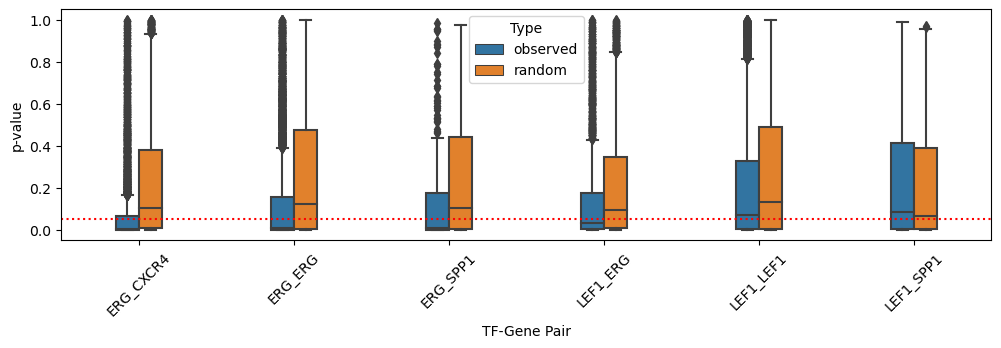

In [11]:
import seaborn as sns
plt.figure(figsize=(12, 3))
sns.boxplot(x='TF-Gene Pair', y='p-value', hue='Type', data=df, width=0.3)
plt.axhline(y=0.05, color='red', linestyle='dotted')
plt.xticks(rotation=45)
plt.show()

In [12]:
significant_pairs = []
for tf_gene_pair, values in scores.items():
    if np.median(values['observed']) < 0.05:
        significant_pairs.append(tf_gene_pair)
print(significant_pairs)

['ERG_CXCR4', 'ERG_ERG', 'ERG_SPP1', 'LEF1_ERG']


[2.4385507  2.4632409  2.4691868  2.4645882  2.4630556  2.470281
 2.465619   2.4692523  2.4674335  0.27242145 0.27391523 0.28191182
 0.29036745 0.29723763 0.30291593 0.3067099  0.31205112 0.31753042]


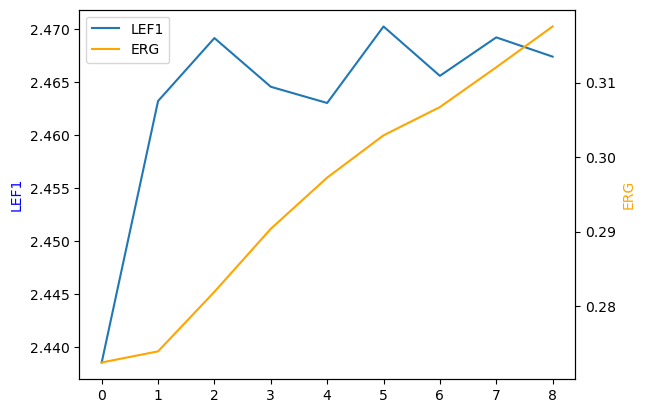

In [122]:
tf = "LEF1"
gene = "ERG"
tf_gene_folder = os.path.join(folder+'DelayPairs/', f"{tf}_{gene}/")
velo_file = tf_gene_folder + tf + '_' + gene + '_velos.csv'
velos = pd.read_csv(velo_file, header=None).values
i, len = 138, velos.shape[1]
print(velos[i])
sample1, sample2 = velos[i, 0:int(len//2)], velos[i, int(len//2):]

fig, ax1 = plt.subplots()
line1, = ax1.plot(sample1, label=tf)
ax1.set_ylabel(tf, color='b')

ax2 = ax1.twinx()
line2, = ax2.plot(sample2, 'orange', label=gene)
ax2.set_ylabel(gene, color='orange')
lines = [line1, line2]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc="upper left")
plt.show()